In [1]:
import logging
import numpy
import numpy as np
import pandas as pd
from math import *
from datetime import datetime
from operator import itemgetter
from zipfile import ZipFile
from io import BytesIO
import pickle
from urllib.request import urlopen

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from numpy import inf
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error



import warnings
warnings.filterwarnings('ignore')

from functions import *
from fair_func import *

In [2]:
from pandas.api.types import CategoricalDtype


<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Loading and preparing the data</span>
</div>

In [3]:
data = pd.read_csv('RAIdata.csv')

<a id="3"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Exploring data</span>
</div>

In [4]:
data.shape

(61321, 206)

In [5]:
data["Default"].value_counts()

0.0    46752
1.0    14569
Name: Default, dtype: int64

In [6]:
data.head().T

,0,1,2,3,4
Unnamed: 0,0.000000,1.0000,2.000000,3.000000,4.0000
Age,54.000000,52.0000,28.000000,40.000000,31.0000
AppliedAmount,8505.000000,2230.0000,530.000000,1380.000000,530.0000
DebtToIncome,0.000000,0.0000,0.000000,0.000000,0.0000
ExpectedLoss,0.118622,0.0592,0.048764,0.071894,0.0437
...,...,...,...,...,...
WorkExperience_2To5Years,0.000000,1.0000,1.000000,0.000000,0.0000
WorkExperience_5To10Years,1.000000,0.0000,0.000000,1.000000,0.0000
WorkExperience_LessThan2Years,0.000000,0.0000,0.000000,0.000000,1.0000
WorkExperience_MoreThan25Years,0.000000,0.0000,0.000000,0.000000,0.0000


<a id="4"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Data bias detection</span>
</div>

<p class='lead'> Definition: </p>

- **Protected group** is a feature $\mathbf{S}$ that belongs to $\mathbf{X}$ having  $\mathbf{N}$ data points and ${D}$ dimensions
- **Advantegous group / Privileged** is a level $\mathbf{T}_{a}$ of the feature $\mathbf{S}$ having $\mathbf{N}_{a}$ data points belonging to $\mathbf{X}$ having a higher probability of favourable outcome and is also called $\mathbf{S}=1$. Also $\mathbf{S_a}$
- **Disadvantegous group / Unprivileged** is a level $\mathbf{T}_{d}$ of the feature  $\mathbf{S}$ having $\mathbf{N}_{d}$ data points belonging to X which has a higher probability of favourable outcome and is also called $\mathbf{S}=0$. Also $\mathbf{S_d}$
- **Actual lables / target** with data point $\mathbf{N}$ are represnted by $\mathbf{Y}$ having values ${y}$
- **Predicted labels** are represented $\hat{Y}$

### Statistical Parity Difference and Disparate Impact  
**Probability of all groups under protected class to have same probability of favourable outcome**  
[Fairness Through Awareness](https://arxiv.org/pdf/1104.3913.pdf)

**Statistical Parity Difference:**
$$
\begin{align}
\mathbb{P}({Y} = 1 {|} \mathbf{S} = \mathbf{T}_{a}) = \mathbb{P}( {Y}=1{|}\mathbf{S} = \mathbf{T}_{d})
\end{align}
$$

**Disparate Impact:**


$$
\begin{align}
\frac{\mathbb{P}(Y=1{|}S=T_a)} {\mathbb{P}(Y=1{|}S=T_a)}
\end{align}
$$

In [7]:
#0 if favourable [false, default = false]
#1 if unfavourable [true, default = True]
fav=0
unfav=int(not fav)

In [8]:
a='Gender_0.0' #Male
b='Education_5.0' #Higher Ed
c='Young' # Age group
d='HomeOwnershipType_1.0' #Owner 
e='HomeOwnershipType_8.0' #Mortgages
f='EmploymentStatus_5.0' #Entrepreneur
g="Tenant" #Tenant

i='LanguageCode_1' #Estonian
j='LanguageCode_2' #English
k="NrOfDependantslessthan3" #No of dependent less than 10 years
l='MaritalStatus_1.0' #Married
m='MaritalStatus_3.0' #Single
n='MaritalStatus_4.0' #Divorced

p="WrExLess10" #Work ex less than 10 years
q="WrExLess5" #Work ex less than 5 years


In [9]:
label_names=['Default']

protected_attribute_names=[a,b,c,d,e,f,g,i,j,k,l,m,n,p,q]

#privileged_groups = [{b: 1}, {c:1}, {d:1}, {e: 1}, {g:1}, {h: 1}, {i:1}, {f:1}, {k:1}] #Male
privileged_groups = [{a :0}, {b :0}, {c :0}, {d :0}, {e :0}, {f :0}, 
                        {g :0}, {i :0}, {j :0}, {k :0}, 
                        {l :0}, {m :0}, {n:0}, {p :0}, {q :0}]



#unprivileged_groups = [{b: 0}, {c:0}, {d:0}, {e: 0}, {g:0}, {h: 0}, {i:0}, {f:0}, {k:0}] #Female


unprivileged_groups = [{a :1}, {b :1}, {c :1}, {d :1}, {e :1}, {f :1}, 
                        {g :1}, {i :1}, {j :1}, {k :1}, 
                        {l :1}, {m :1}, {n:1}, {p :1}, {q :1}]


input_dataframe = data.copy()
INPUT_DATAFRAME = input_dataframe
LABEL_NAMES = label_names
PROTECTED_ATTRIBUTE_NAMES = protected_attribute_names
PRIVILEGED_GROUPS = privileged_groups
UNPRIVILEGED_GROUP = unprivileged_groups


SP=[]
DI=[]
Protected=[]
for groupe in range(0, len(protected_attribute_names)):
    protected_attribute_name = list(privileged_groups[groupe].keys())[0]
    privileged_group_protected_attribute_value = PRIVILEGED_GROUPS[groupe][protected_attribute_name]
    unprivileged_group_protected_attribute_value = UNPRIVILEGED_GROUP[groupe][protected_attribute_name]
    print(protected_attribute_name, privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)
    
    stat_parity, disprate_impact = stat_parity_test(data, protected_attribute_name, 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)
    
    SP.append(stat_parity)
    DI.append(disprate_impact)
    Protected.append(protected_attribute_name)
    
    print ("")

Gender_0.0 0 1
Statistical Parity Difference 0.0659878494069962
Disparate Impact 1.0924819563899022

Education_5.0 0 1
Statistical Parity Difference 0.060003289360061496
Disparate Impact 1.0801386554367447

Young 0 1
Statistical Parity Difference -0.07241068853497912
Disparate Impact 0.9098162947410234

HomeOwnershipType_1.0 0 1
Statistical Parity Difference 0.03308219776293675
Disparate Impact 1.0441758557196397

HomeOwnershipType_8.0 0 1
Statistical Parity Difference 0.10150342452057504
Disparate Impact 1.134839797576764

EmploymentStatus_5.0 0 1
Statistical Parity Difference -0.08650158252530704
Disparate Impact 0.8868813799464257

Tenant 0 1
Statistical Parity Difference -0.0573416833805781
Disparate Impact 0.9259271443038499

LanguageCode_1 0 1
Statistical Parity Difference 0.03872787648108733
Disparate Impact 1.0530500032910963

LanguageCode_2 0 1
Statistical Parity Difference -0.04328406445997812
Disparate Impact 0.9432495336719515

NrOfDependantslessthan3 0 1
Statistical Parity

<div class="alert alert-block alert-info">
<b>Remember:</b> 

- Statistical Parity Difference should be between -0.1 and 0.1
- Disparate Impact should be between 0.90 and 1.10
- Negative sign shows that: the unprivileged group is worse in favourable outcome that privileged class (as the formula used it probability of unprivileged - probability of privileged), so in case you see a positive value, you may want to reconsider your choice of privileged and unprivileged groups <b>using the next two plots</b>
</div>


In [10]:
SP, DI, Protected
d = pd.DataFrame({'Protected_feature':Protected,'Statistical_Parity':SP,'Disparate_Impact':DI})
d['DI_normal']=d["Disparate_Impact"].apply(lambda x: 1/x if x < 1 else x)
d['SP_normal']=d["Statistical_Parity"].apply(lambda x: abs(x) if x < 0 else x)
#d

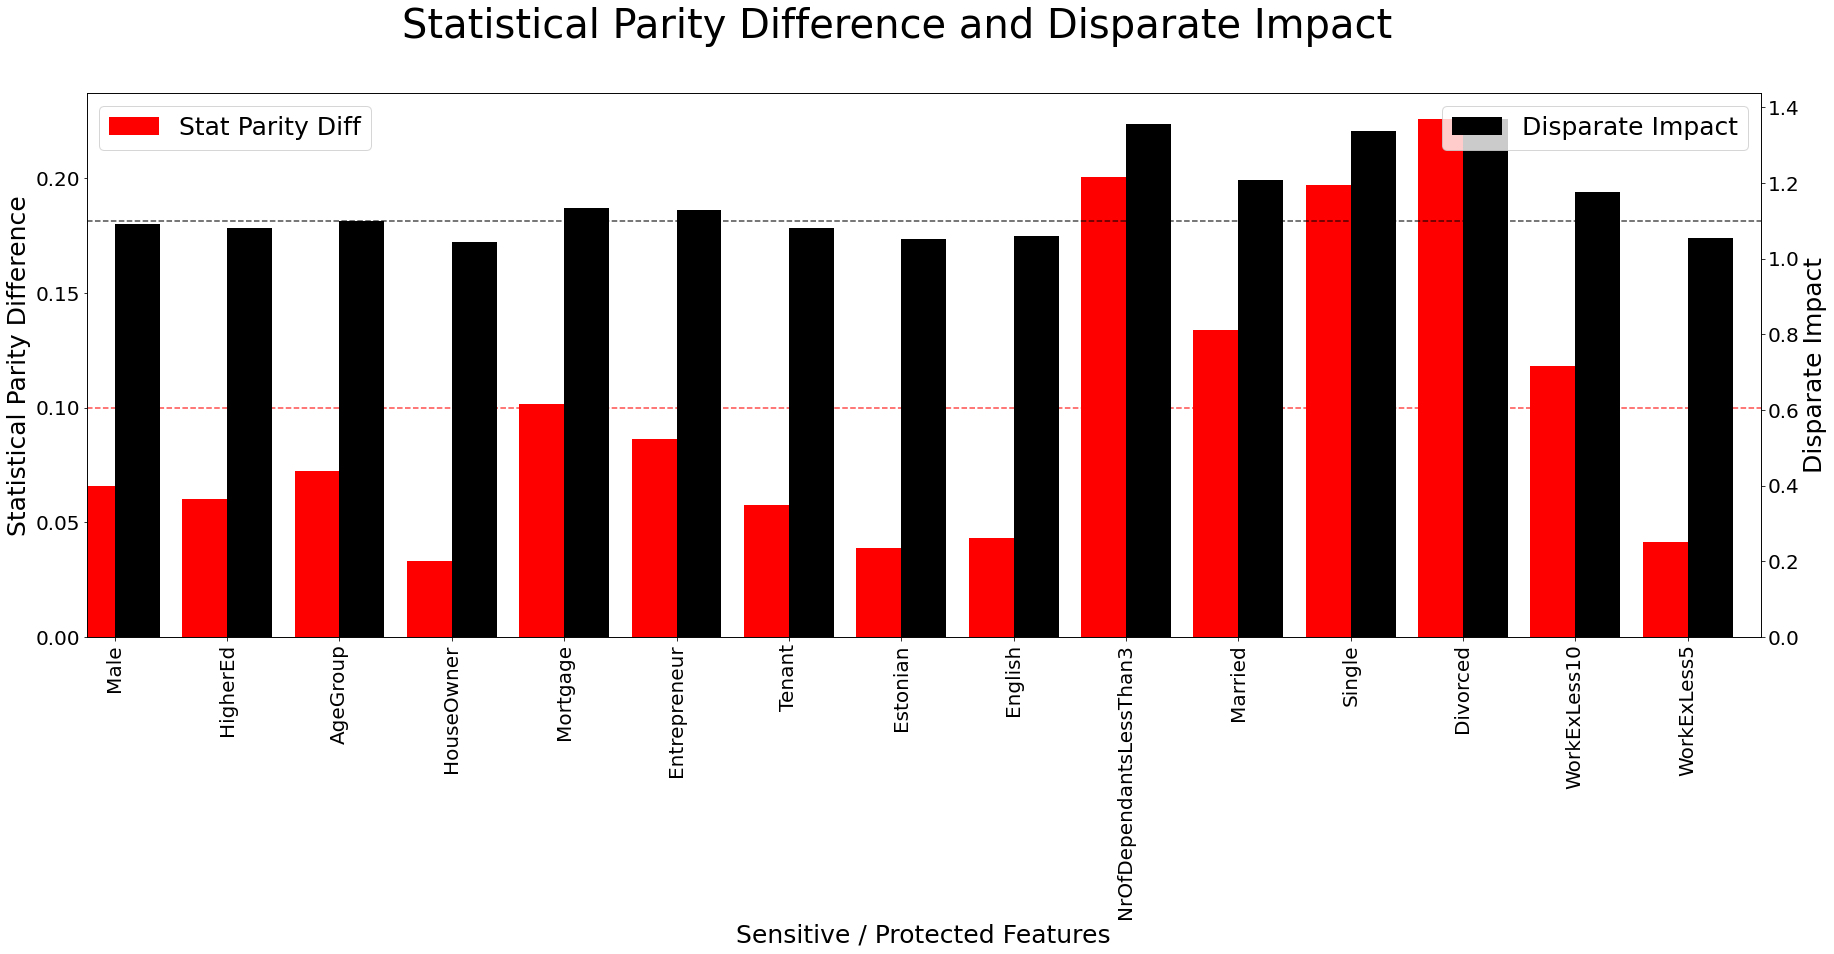

In [11]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.


fig.suptitle('Statistical Parity Difference and Disparate Impact', fontsize=40, y=1)


width = 0.4
d.plot(x ='Protected_feature', y='SP_normal', kind = 'bar', ax=ax, width=width, 
       position=1, color='red', legend=False, figsize=(30,10), fontsize=20)

d.plot(x ='Protected_feature', y='DI_normal', kind = 'bar', ax=ax2, width=width, 
       position=0, color='black', legend=False, figsize=(30,10), fontsize=20)

ax.axhline(y=0.1, linestyle='dashed', alpha=0.7, color='red')
ax2.axhline(y=1.10, linestyle='dashed', alpha=0.7, color='black')


patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['Stat Parity Diff'], loc='upper left', fontsize=25)

patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, ['Disparate Impact'], loc='upper right', fontsize=25)



labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0] = 'Male'
labels[1] = 'HigherEd'
labels[2] = 'AgeGroup'
labels[3] = 'HouseOwner'
labels[4] = 'Mortgage'
labels[5] = 'Entrepreneur'
labels[6] = 'Tenant'
labels[7] = 'Estonian'
labels[8] = 'English'
labels[9] = 'NrOfDependantsLessThan3'
labels[10] = 'Married'
labels[11] = 'Single'
labels[12] = 'Divorced'
labels[13] = 'WorkExLess10'
labels[14] = 'WorkExLess5'

ax.set_xticklabels(labels)


#ax2.axhline(y=.80, linestyle='dashed', alpha=0.7, color='black')

ax.set_xlabel('Sensitive / Protected Features', fontsize=25)

ax.set_ylabel('Statistical Parity Difference', fontsize=25)
ax2.set_ylabel('Disparate Impact', fontsize=25)

plt.show()

#fig.savefig('SPDnDI.svg', format='svg', dpi=500, bbox_inches='tight')
#fig.savefig('SPDnDI.png', format='png', dpi=500, bbox_inches='tight')
#beingsaved = plt.figure()
#beingsaved.savefig('SPDnDI.eps', format='eps', dpi=500)




<div class="alert alert-block alert-success">
<b>Inference:</b>
It's clearly visible that 5 sensitive features (NrOfDependantslessthan3, Married, Single, Divorced and WorkExLess10) are having bias as per Statistical Parity Difference and Disparate Impact
</div>

### Frequency for sensitive features

In [12]:
for groupe in range(0, len(protected_attribute_names)):
    protected_attribute_name = list(privileged_groups[groupe].keys())[0]
    #print(protected_attribute_name)
    #print(data[protected_attribute_name].value_counts())
    #print ("-------------------------------------")

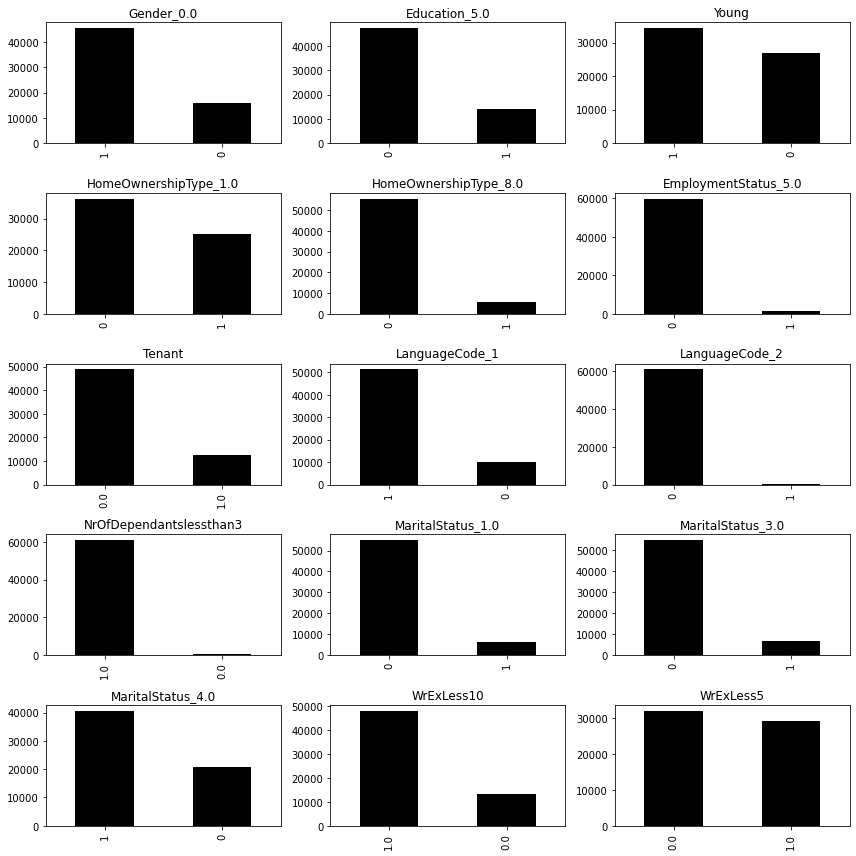

In [13]:
fig = plt.figure()

#ax = sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5)
#ax.set_title("Frequency of each sensitive features", fontsize=15) # fontweight="bold"



for groupe in range(0, len(protected_attribute_names)):
    #plt.figure(figsize = (4,2))
    protected_attribute_name = list(privileged_groups[groupe].keys())[0]
    #data[protected_attribute_name].value_counts().plot(kind='bar')
    ax = fig.add_subplot(5,3,groupe+1)

    
    vc=data[protected_attribute_name].value_counts()
    ax=vc.plot(kind='bar', figsize=(12,12), title=protected_attribute_name, color = 'black')
    #axes.plot(vc)


plt.tight_layout()
plt.show()

### Cross-tabs for sensitive features

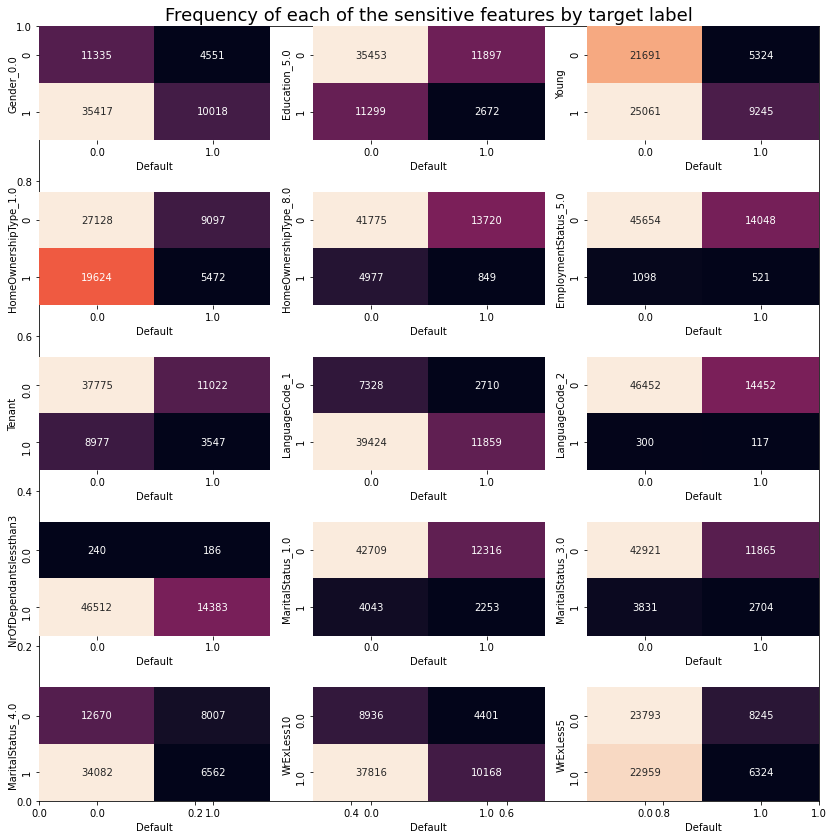

In [14]:
#fig = plt.figure()
fig, ax = plt.subplots(figsize=(12,12))
#plt.suptitle('lalala')
ax.set_title("Frequency of each of the sensitive features by target label", fontsize=18)


for groupe in range(0, len(protected_attribute_names)):
    #_,ax = plt.figure(figsize = (8,8))
    protected_attribute_name = list(privileged_groups[groupe].keys())[0]
    #data[protected_attribute_name].value_counts().plot(kind='bar')
    ax = fig.add_subplot(5,3,groupe+1)

    plotdf=pd.crosstab(data[protected_attribute_name], data['Default'])
    ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False, ax=ax)    #axes.plot(vc)
    #print (type(axes))


plt.tight_layout()
plt.show()

### Calculation for Statistical Parity and Disparate Impact for a given protected feature
**Declaring the protected feature (a.k.a sensitive feature) and privileged & unprivileged groups**  
Here we are trying to find bias on basis of a sensitive feature (that explains if the customer is Married or Otherwise)

In [17]:
choice = 'dep_4_wl10' #'MaritalStatus_1.0'
pval = 0 #privileged : see the above heatmaps
upval = int(not pval) #Unprivileged
#['HomeOwnershipType_8.0', 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0', 'WrExLess10']

In [18]:

label_names=['Default']
protected_attribute_names=[choice]
privileged_groups=[{choice: pval}]
unprivileged_groups=[{choice: upval }]

In [19]:
stat_parity, disprate_impact = stat_parity_test(data, 'Tenant', 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)

Statistical Parity Difference -0.0573416833805781
Disparate Impact 0.9259271443038499


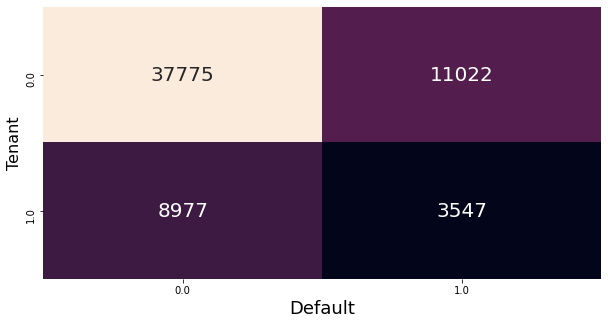

In [20]:
plt.subplots(figsize=(10,5))
plotdf=pd.crosstab(data['Tenant'], data['Default'], rownames=['Tenant'])
ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False, annot_kws={'size':20})    #axes.plot(vc)
plt.xlabel('Default', fontsize=18)
plt.ylabel('Tenant', fontsize=16)

plt.show()    #axes.plot(vc)
plt.show()

In [21]:
stat_parity, disprate_impact = stat_parity_test(data, 'MaritalStatus_4.0', 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)

Statistical Parity Difference 0.22579121831790572
Disparate Impact 1.368483427084399


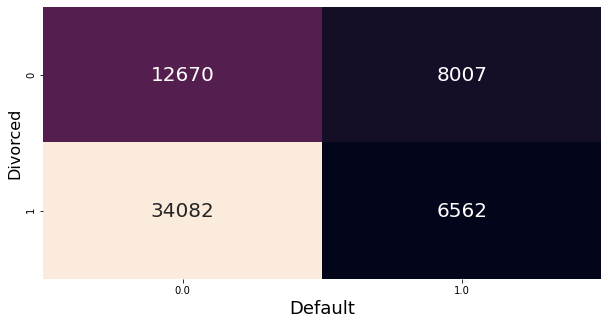

In [22]:
plt.subplots(figsize=(10,5))
plotdf=pd.crosstab(data['MaritalStatus_4.0'], data['Default'], rownames=['Divorced'])
ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False, annot_kws={'size':20})    #axes.plot(vc)
plt.xlabel('Default', fontsize=18)
plt.ylabel('Divorced', fontsize=16)

plt.show()    #axes.plot(vc)
plt.show()

In [23]:
stat_parity, disprate_impact = stat_parity_test(data, 'MaritalStatus_1.0', 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)

Statistical Parity Difference -0.1340207177400593
Disparate Impact 0.8273317100927963


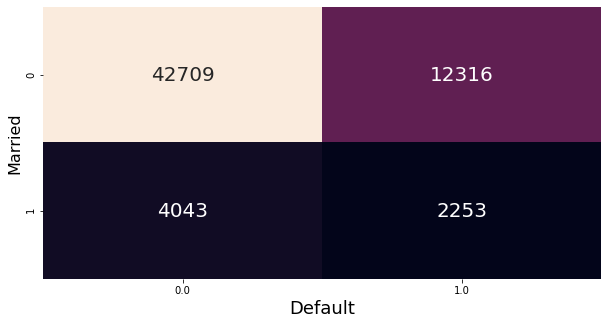

In [24]:
plt.subplots(figsize=(10,5))
plotdf=pd.crosstab(data['MaritalStatus_1.0'], data['Default'], rownames=['Married'])
ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False, annot_kws={'size':20})    #axes.plot(vc)
plt.xlabel('Default', fontsize=18)
plt.ylabel('Married', fontsize=16)

plt.show()    #axes.plot(vc)
plt.show()

In [25]:
stat_parity, disprate_impact = stat_parity_test(data, 'WrExLess10', 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)

Statistical Parity Difference 0.11808028634072942
Disparate Impact 1.1762350916434992


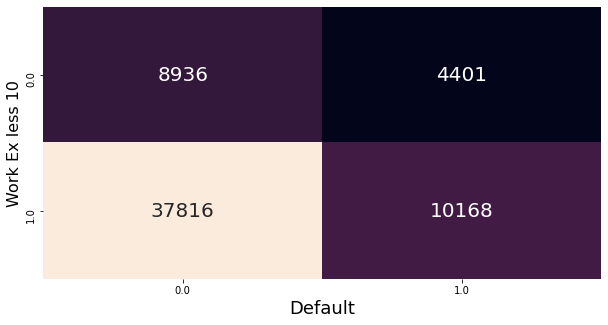

In [26]:
plt.subplots(figsize=(10,5))
plotdf=pd.crosstab(data['WrExLess10'], data['Default'], rownames=['Work Ex less 10'])
ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False, annot_kws={'size':20})    #axes.plot(vc)
plt.xlabel('Default', fontsize=18)
plt.ylabel('Work Ex less 10', fontsize=16)

plt.show()

In [29]:
data['dep_MS4_wex10'] = data[['NrOfDependantslessthan3','MaritalStatus_4.0', 'WrExLess10']].min(axis=1)

In [30]:
stat_parity, disprate_impact = stat_parity_test(data, 'dep_MS4_wex10', 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)

Statistical Parity Difference 0.2126728213290332
Disparate Impact 1.3369736951591555


In [31]:
data['Age'].describe()

count    61321.000000
mean        38.872409
std         11.922168
min          0.000000
25%         29.000000
50%         37.000000
75%         47.000000
max         77.000000
Name: Age, dtype: float64

In [32]:
agebin = [20, 40, 50, 60]

In [33]:
data["A0-20"] = data["Age"].apply(lambda x: 1 if x > 0 and x < 20 else 0)
data["A20-30"] = data["Age"].apply(lambda x: 1 if x > 20 and x < 30 else 0)
data["A30-40"] = data["Age"].apply(lambda x: 1 if x > 30 and x < 40 else 0)
data["A40-50"] = data["Age"].apply(lambda x: 1 if x > 40 and x < 50 else 0)
data["A50up"] = data["Age"].apply(lambda x: 1 if x > 50 else 0)


In [34]:
print("Age less than 20") 
stat_parity, disprate_impact = stat_parity_test(data, "A0-20", 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)


print("Age 20-30")    
stat_parity, disprate_impact = stat_parity_test(data, "A20-30", 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)
    
    
print("Age 30-40") 
stat_parity, disprate_impact = stat_parity_test(data, "A30-40", 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)
    

print("Age 40-50")    
stat_parity, disprate_impact = stat_parity_test(data, "A40-50", 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)

print("Age 50+") 
stat_parity, disprate_impact = stat_parity_test(data, "A50up", 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)
  

Age less than 20
Statistical Parity Difference -0.004575749620234548
Disparate Impact 0.993998583994719
Age 20-30
Statistical Parity Difference -0.09611970460070407
Disparate Impact 0.8776615229333099
Age 30-40
Statistical Parity Difference 0.006020685359354516
Disparate Impact 1.0079137391634394
Age 40-50
Statistical Parity Difference 0.04941587066300568
Disparate Impact 1.0657195566030375
Age 50+
Statistical Parity Difference 0.05959485968366374
Disparate Impact 1.0793019995625828


In [35]:
for i in agebin:
    print ('when the age bin cut-off is:', i)
    data["Yng_b"] = data["Age"].apply(lambda x: "1" if x < i else "0")
    protected_attribute_name = "Yng_b"
    data["Yng_b"]=data["Yng_b"].astype(str).astype(int)
    stat_parity, disprate_impact = stat_parity_test(data, protected_attribute_name, 'Default', fav,
              privileged_group_protected_attribute_value, unprivileged_group_protected_attribute_value)
    
    print ("")

when the age bin cut-off is: 20
Statistical Parity Difference -0.03818935104428711
Disparate Impact 0.9499288227723014

when the age bin cut-off is: 40
Statistical Parity Difference -0.07241068853497912
Disparate Impact 0.9098162947410234

when the age bin cut-off is: 50
Statistical Parity Difference -0.06160238473630952
Disparate Impact 0.924100689990556

when the age bin cut-off is: 60
Statistical Parity Difference -0.06619197700648272
Disparate Impact 0.9197113914982438



---

In [36]:
choice = 'dep_4_wl10' #'MaritalStatus_1.0'
pval = 0 #privileged : see the above heatmaps
upval = int(not pval) #Unprivileged
#['HomeOwnershipType_8.0', 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0', 'WrExLess10']

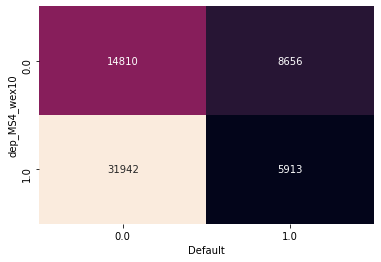

In [37]:
plotdf=pd.crosstab(data['dep_MS4_wex10'], data['Default'])
ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False)    #axes.plot(vc)
plt.show()
#print (type(axes))
